# Mode Connectivity of Neural Networks (Part 2)

<br>

## Introduction

In this part of the project we will implement a different path algorithm based on property of a well trained network - **dropout-stability**. Notably enough, the approach is constructive, i.e., we get a closed form expression for piecewise linear path between minimas found by SGD with *no optimization required*.

<br>

In [44]:
# importing all packages necessary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### SGD Solutions for Large Network Width are Dropout Stable

In this section, we will train a couple of two-layer networks with SGD to see that when the number of neurons $N$ is sufficiently large the loss of full network and the network with half of connections (suitably rescaled) are close through the whole training proceedure.

#### Setup

In order to be aligned with theory we consider a slightly different version of the network and training algorithm. In particular, the two-layer mean-field network

$$
y_{{\theta}_N}({x}) = \frac{1}{N} \sum_{i=1}^N a_i \sigma({w}_i^T {x} + b_i),
$$

where $x \in \mathbb{R}^d$ is network input, $\theta_N = \{(a_i \in \mathbb{R}, w_i \in \mathbb{R}^d, b_i \in \mathbb{R})\}_{i=1}^N \in \mathbb{R}^{d+2}$ are network parameters and $\sigma: \mathbb{R} \rightarrow \mathbb{R}$ stands for the activation function. The initial values for parameters are drawn from normal distribution with variance independent from $N$, e.g., from normal distribution with unit variance. This ensures that the network output concentrates to the mean value as $N \rightarrow \infty$.

**Remark.** Notice $\frac{1}{N}$ factor in network definition.

For optimization algorithm we consider SGD with rescaled by a factor of $N$ gradient (in order to make theory work):

$$
\theta^{k+1}_N = \theta^{k}_N - \alpha \nabla_{\theta}L(y^k,y_{{\theta_N^k}}({x}^k)) \cdot N,
$$

where $L$ defines a loss function and $(x^k, y^k) \sim \mathcal{D}$ is current training example and $\mathcal{D}$ si data distribution.

#### Dropout stability

First we define the dropout network with corresponding dropout pattern $A \in \{1,\cdots,N\}$

$$
y_{{\theta}_N, A}(x) = \frac{1}{|A|} \sum_{i\in A} a_i \sigma({w}_i^T {x} + b_i),
$$

where $|A|$ stands for cardinality of set $A$.

The set of network parameters $\theta_N$ is called dropout stable if there exists a dropout pattern $A$ such that

$$
|\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta_{N},A}}({x})) - \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta_{N}}}({x}))| \leq \varepsilon_D,
$$

for some small value of $\varepsilon_D$.

Without loss of generality we can assume that the dropout pattern is always $A = \{1,\cdots,N/2\}$ and define the shorthand notation

$$
y_{{\theta}_N, A}(x) = y_{{\theta}_{N/2}}(x).
$$

It can be shown that during SGD

$$
|\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta^k_{N},N/2}}({x})) - \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta^k_{N}}}({x}))| \rightarrow 0
$$

for squared risk, i.e., $L(y,y') = (y-y')^2$ as long as $N \rightarrow \infty$ and $\alpha \rightarrow 0$. In particular, if $K$ is total number of iterations then $K\alpha = \textrm{const}$. For example, we can pick $\alpha = \frac{C_1}{N}$ and $K = CN$ for some constants $C_1$ and $C_2$.

**Remark:** Aforementioned relation between number of iterations, learning rate and width of network is crucial. It should be preserved later when we train two networks of different sizes.

In a nutshell, according to aforementioned we expect the difference between the *dropout* network and full one to vanish as width $N$ grows larger with step size $\alpha \rightarrow 0$.

#### Multiple outputs 

We defined dropout network for the case when the number of outputs $M=1$. Now consider $M>1$. In this case, we have

$$
y^m_{{\theta}_N}({x}) = \frac{1}{N} \sum_{i=1}^N a^m_i \sigma({w}_i^T {x} + b_i), \quad m \in \{1,\cdots,M\},
$$

thus, the dropout network will correspond to dropping the half of $a_i^m$ for current $m$ and rescaling remaining ones, i.e.,

$$
y^m_{{\theta}_{N/2}}(x) = \frac{2}{N} \sum_{i=1}^{N/2} a^m_i \sigma({w}_i^T {x} + b_i).
$$

#### MNIST Dataset

First we download the dataset and normalize each image for optimization stability. ``train_loader`` loader and ``test_loader`` are iterators for corresponding parts of the dataset.

In [431]:
# convert image to tensor for PyTorch, and normalize with mean and std for stability
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# downloading training and test parts of MNIST dataset
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)

# get train and test samplers with B=100 for train and B=1000 for test
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000, shuffle=False)

#### Network Definition

Define two layer network described above with $N$ neurons in hidden layer and 10 outputs for MNIST classification task. For activation use Rectified Linear Unit (ReLU). Network gets as an input flattened to a vector of size $28\times28$ image.

**Remark:** ``nn.Linear`` initializes ``.weight from`` distribution with variance that vanishes with $N \rightarrow \infty$. Thus, to define network defined above you need to reinit the weights $w$ and $a$ from distribution with constant variance. **Use the values provided for your group.** **Keep init for ``.bias`` of the first layer as is.**


To disable bias in last linear layer, i.e., to get only $a$'s use flag: ``bias=False`` in ``nn.Linear(...)``. Weight for each ``nn.Linear`` object can be accessed via ``object.weight``. Reinit of weight should be done in init method of class.

**Do not forget ot rescale output of network by $\frac{1}{N}$**.

In [494]:
class FCN(nn.Module):
    def __init__(self, N):
        super(FCN, self).__init__()
        self.N = N
        # => define layers and reinit a, w using layer.weight.data.normal_() or other dist depending on your group
        self.fc1 = nn.Linear(28 * 28, N)
        self.fc1.weight.data.normal_(mean=0, std=1.2)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(N, 10,bias=False)
        self.fc2.weight.data.normal_(mean=0, std=1.2)
        coin = np.random.randint(0,2)
        if coin==0:
            self.fc2.bias=torch.nn.Parameter(torch.Tensor(np.random.uniform(low=0.5, high=1.51, size=10)))
        if coin==1:
            self.fc2.bias=torch.nn.Parameter(torch.Tensor(np.random.uniform(low=-1.5, high=-0.51, size=10)))
    def forward(self, x):
        # => Implement a forward pass
        output = self.fc1(x)
        output = self.act(output)
        output = self.fc2(output)
        return output

#### Training with different $N$'s

Below we provide a function to compute test loss and test classification error to estimate $\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta^k_{N},N/2}}({x}))$ and $\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta^k_{N}}}({x}))$ during training, i.e., metrics for full and dropout network. **You can modify the function to print additional info if you need.**

In [433]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1,28 * 28)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    #print('Accuracy of the network on the 1000 test images: {} %'.format(100 * correct / len(test_loader.dataset)))
    
    return test_loss, 1. - 1. * correct / len(test_loader.dataset), 100 * correct / len(test_loader.dataset)

Implement a function which takes full network and returns its dropout version, i.e., where $\hat{a}_j^k = 0$ for $j \geq N/2,\ k \in \{1,\cdots,10\}$ and  $\hat{a}_j^k = 2 a_j^k$ for $j < N/2,\ k \in \{1,\cdots,10\}$. In other words, we set half of the final layer weights to zero and rescale the remaining ones by factor of two.

In [434]:
def get_dropout_network(model,N):
    model_dropout = deepcopy(model)
    # => Drop and rescale a's 
    model_dropout.fc2.weight.data[:,int(N/2):]=0
    model_dropout.fc2.weight.data[:,0:int(N/2)]*=2
    return model_dropout

Now you need to train two networks with sizes $N=N_1$ and $N=N_2$. **Use $N_1$ and $N_2$ values provided for your group.**

As it was mentioned before pick learning rate $\alpha$ and total number of iterations $K$ such that $\alpha=C_1/N$ and $K = C_2 N$. In particular, if for $N=800$ the value of learning rate is $\alpha$ and number of iterations is equal to $K$, then for $N=3200$ the learning rate should be set to $\alpha / 4$ and number of iterations to $4K$.

Through training we would like to track the **test loss** and **test classification error** for both full network and dropout network. To evaluate the metrics use ``test(...)`` function defined above. Save corresponding values to plot later.
Define a uniform grid in **log** scale w.r.t. the total number of iterations and evaluate metrics at each point $k$ of grid.

**Remark:** Do not forget to rescale gradients by a factor of $N$ during training in accrodance with theory mentioned before.

Implement a function below which trains a network of size $N$ and returns 

$$\text{(list of test losses and errors of full network, list of test losses and errors of dropout network, final_model)}$$

The final full model should achieve reasonable accuracy, i.e. $\approx 97-98$%.

**Note:** ``population_`` prefix stands for loss.

In [450]:
def train(model, train_loader, optimizer, epoch,N,epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader): # sample subset of dataset - (x,y)
        data = data.view(-1,28 * 28) # reshape 2d image to vector of size 28x28
        target = target
        # => Implement a computation of gradient for current batch of data
        optimizer.zero_grad()
        output=model(data)/N
        loss = F.cross_entropy(output, target)  
        loss.backward()
        for p in model.parameters():
            p.grad *= N  # or whatever other operation
        optimizer.step()
        # => Implement progress tracker
        if batch_idx % 60 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, epochs, batch_idx, len(train_loader), loss.item()))

In [451]:
def get_curves_and_model(N,learning_rate,epochs):
    population_curve, error_curve = [], [] # list to store test losses and errors of full network
    population_curve_dropout, error_curve_dropout = [], [] # list to store test losses and errors of dropout network
    model = FCN(N)
    #learning_rate = 0.001
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # => Implementation
    for epoch in range(1, epochs + 1):
        train(model,train_loader,optimizer,epoch,N,epochs)
        population_curve.append(test(model,test_loader)[0])
        error_curve.append(test(model,test_loader)[1])
        print(test(model,test_loader)[2])
        model_dropout=get_dropout_network(model,N)
        population_curve_dropout.append(test(model_dropout,test_loader)[0])
        error_curve_dropout.append(test(model_dropout,test_loader)[1])
        print(test(model_dropout,test_loader)[2])
    return population_curve, error_curve, population_curve_dropout, error_curve_dropout, model

Get curves and network for $N=N_1$.

In [452]:
N_1 = 50# paste your group N_1 value
learning_rate = 0.001
epochs=30
population_curve_N_1, error_curve_N_1, \
population_curve_dropout_N_1, error_curve_dropout_N_1, model_N_1 = get_curves_and_model(N_1,learning_rate,epochs)

Epoch [1/30], Step [0/600], Loss: 6.1347
Epoch [1/30], Step [60/600], Loss: 1.2693
Epoch [1/30], Step [120/600], Loss: 1.1422
Epoch [1/30], Step [180/600], Loss: 0.6575
Epoch [1/30], Step [240/600], Loss: 0.7487
Epoch [1/30], Step [300/600], Loss: 0.5734
Epoch [1/30], Step [360/600], Loss: 0.5189
Epoch [1/30], Step [420/600], Loss: 0.7014
Epoch [1/30], Step [480/600], Loss: 0.6638
Epoch [1/30], Step [540/600], Loss: 0.5113
84.41
48.33
Epoch [2/30], Step [0/600], Loss: 0.3630
Epoch [2/30], Step [60/600], Loss: 0.5434
Epoch [2/30], Step [120/600], Loss: 0.5596
Epoch [2/30], Step [180/600], Loss: 0.4860
Epoch [2/30], Step [240/600], Loss: 0.4094
Epoch [2/30], Step [300/600], Loss: 0.4330
Epoch [2/30], Step [360/600], Loss: 0.6272
Epoch [2/30], Step [420/600], Loss: 0.3740
Epoch [2/30], Step [480/600], Loss: 0.4499
Epoch [2/30], Step [540/600], Loss: 0.2674
87.94
50.39
Epoch [3/30], Step [0/600], Loss: 0.2066
Epoch [3/30], Step [60/600], Loss: 0.4666
Epoch [3/30], Step [120/600], Loss: 0.5

Plot two figures: 

1) test risks of full and dropout network during training

2) test errors of full and dropout network during training

Use log scale for $x$-axis (iterations).

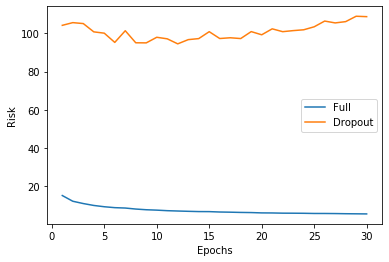

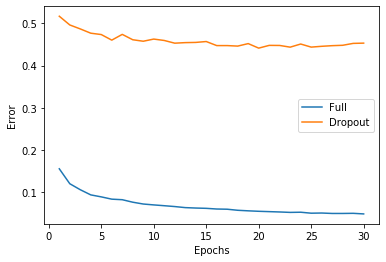

In [563]:
# => Plot 
plt.figure()
plt.plot(np.arange(1,epochs + 1,1),population_curve_N_1,label="Full")
plt.plot(np.arange(1,epochs + 1,1),population_curve_dropout_N_1,label="Dropout")
plt.xlabel('Epochs')
plt.ylabel('Risk')
plt.legend(loc='best')
plt.savefig("N50_risk.jpg")
plt.figure()
plt.plot(np.arange(1,epochs + 1,1),error_curve_N_1,label="Full")
plt.plot(np.arange(1,epochs + 1,1),error_curve_dropout_N_1,label="Dropout")
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.savefig("N50_error.jpg")

Get curves and network for $N=N_2$.

In [454]:
N_2 = 2000 # paste your group N_2 value
learning_rate=0.001
epochs=30
population_curve_N_2, error_curve_N_2, \
population_curve_dropout_N_2, error_curve_dropout_N_2, model_N_2 = get_curves_and_model(N_2,learning_rate,epochs)

Epoch [1/30], Step [0/600], Loss: 2.4642
Epoch [1/30], Step [60/600], Loss: 0.7141
Epoch [1/30], Step [120/600], Loss: 0.5026
Epoch [1/30], Step [180/600], Loss: 0.4143
Epoch [1/30], Step [240/600], Loss: 0.3485
Epoch [1/30], Step [300/600], Loss: 0.3523
Epoch [1/30], Step [360/600], Loss: 0.2535
Epoch [1/30], Step [420/600], Loss: 0.2748
Epoch [1/30], Step [480/600], Loss: 0.2884
Epoch [1/30], Step [540/600], Loss: 0.4073
92.54
89.6
Epoch [2/30], Step [0/600], Loss: 0.2130
Epoch [2/30], Step [60/600], Loss: 0.3484
Epoch [2/30], Step [120/600], Loss: 0.2476
Epoch [2/30], Step [180/600], Loss: 0.3082
Epoch [2/30], Step [240/600], Loss: 0.2398
Epoch [2/30], Step [300/600], Loss: 0.3164
Epoch [2/30], Step [360/600], Loss: 0.1602
Epoch [2/30], Step [420/600], Loss: 0.1459
Epoch [2/30], Step [480/600], Loss: 0.3009
Epoch [2/30], Step [540/600], Loss: 0.3006
93.77
91.51
Epoch [3/30], Step [0/600], Loss: 0.2624
Epoch [3/30], Step [60/600], Loss: 0.2843
Epoch [3/30], Step [120/600], Loss: 0.23

Plot the same figures but for $N=N_2$. **Did full network and dropout network become closer?**

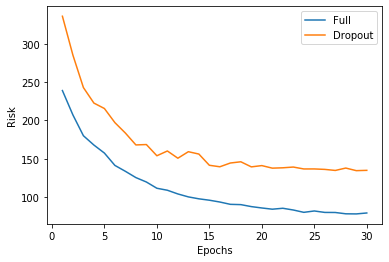

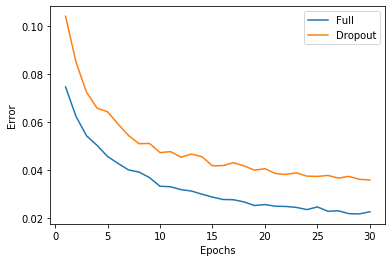

In [564]:
# => Plot 
plt.figure()
plt.plot(np.arange(1,epochs + 1,1),population_curve_N_2,label="Full")
plt.plot(np.arange(1,epochs + 1,1),population_curve_dropout_N_2,label="Dropout")
plt.xlabel('Epochs')
plt.ylabel('Risk')
plt.legend(loc='best')
plt.savefig("N2000_risk.jpg")
plt.figure()
plt.plot(np.arange(1,epochs + 1,1),error_curve_N_2,label="Full")
plt.plot(np.arange(1,epochs + 1,1),error_curve_dropout_N_2,label="Dropout")
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.savefig("N2000_error.jpg")

### Constructing a path

As it was mentioned previously in introduction dropout stability of solution allows to obtain a closed form of piece-wise linear path which connects two solutions. Before going straight to the point we need to train another network with $N=N_2$ neurons (for second solution).

In [458]:
population_curve_N_2_2, error_curve_N_2_2, \
population_curve_dropout_N_2_2, error_curve_dropout_N_2_2, model_N_2_2 = get_curves_and_model(N_2,learning_rate,epochs)

Epoch [1/30], Step [0/600], Loss: 2.5285
Epoch [1/30], Step [60/600], Loss: 0.7036
Epoch [1/30], Step [120/600], Loss: 0.3526
Epoch [1/30], Step [180/600], Loss: 0.3785
Epoch [1/30], Step [240/600], Loss: 0.4282
Epoch [1/30], Step [300/600], Loss: 0.2914
Epoch [1/30], Step [360/600], Loss: 0.3841
Epoch [1/30], Step [420/600], Loss: 0.2747
Epoch [1/30], Step [480/600], Loss: 0.2641
Epoch [1/30], Step [540/600], Loss: 0.3198
92.13
88.95
Epoch [2/30], Step [0/600], Loss: 0.1665
Epoch [2/30], Step [60/600], Loss: 0.3452
Epoch [2/30], Step [120/600], Loss: 0.2262
Epoch [2/30], Step [180/600], Loss: 0.3186
Epoch [2/30], Step [240/600], Loss: 0.1560
Epoch [2/30], Step [300/600], Loss: 0.2354
Epoch [2/30], Step [360/600], Loss: 0.2255
Epoch [2/30], Step [420/600], Loss: 0.2714
Epoch [2/30], Step [480/600], Loss: 0.1822
Epoch [2/30], Step [540/600], Loss: 0.1550
93.65
91.61
Epoch [3/30], Step [0/600], Loss: 0.2414
Epoch [3/30], Step [60/600], Loss: 0.2158
Epoch [3/30], Step [120/600], Loss: 0.2

In [514]:
model_1 = deepcopy(model_N_2)
model_2 = deepcopy(model_N_2_2)
#list(model_1.parameters())

#model_1.fc2.bias

#### Piece-wise Linear Path

Assume that we have two dropout stable sets of parameters $\theta$ and $\theta'$, i.e.,

$$
|\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta,N/2}}({x})) - \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta}}({x}))| \leq \varepsilon, \quad |\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta',N/2}}({x})) - \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta'}}({x}))| \leq \varepsilon
$$

For some loss $L$ which is convex in parameters of the last layer, i.e., $a$'s.

Now consider the case where there is no bias in the first layer, or simply add $1$ to the feature vector $x$ and increase dimension of $w$ by 1. **Provide a proof for lemma below**.

**Lemma.** Consider a two-layer mean-field network with one output and some activation $\sigma$. Let $\theta=((a_1, w_1), (a_2, w_2), \ldots, (a_N, w_N))$ and $\theta'=((a_1', w_1'), (a_2', w_2'), \ldots, (a_N', w_N'))$. Assume that $N$ is even. Consider the piecewise linear path in parameter space that connects $\theta$ to $\theta'$ via the following intermediate points:

\begin{equation}
\begin{split}
\theta_1&=((2a_1, w_1), (2a_2, w_2), \ldots, (2a_{N/2}, w_{N/2}), (0, w_{N/2+1}), (0, w_{N/2+2}), \ldots, (0, w_N)),\\
\theta_2&=((2a_1, w_1), (2a_2, w_2), \ldots, (2a_{N/2}, w_{N/2}), (0, w_{1}'), (0, w_{2}'), \ldots, (0, w_{N/2}')),\\
\theta_3&=((0, w_1), (0, w_2), \ldots, (0, w_{N/2}), (2a_1', w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}')),\\
\theta_4&=((0, w_1'), (0,w_2'), \ldots, (0,w_{N/2}'), (2a_1',w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}')),\\
\theta_5&=((2a_1', w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}'), (0, w_1'), (0, w_2'), \ldots, (0, w_{N/2}')),\\
\theta_6&=((2a_1', w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}'), (0, w_{N/2+1}'), (0, w_{N/2+2}'), \ldots, (0, w_N')).
\end{split}
\end{equation}

The loss along this path is upper bounded by $\max(\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta}}({x})), \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta'}}({x})))+\varepsilon$. 

**Remark:** The path consists of linear segments, i.e., 

$$
\theta(t) = (1-t)\theta_{k-1} + t\theta_{k}, \quad t \in [0,1].
$$

**Proof of Lemma:** *your_proof_goes_here :)*

#### Implementation

In this task you would need to implement a path defined above and evaluate the test loss for 10 points in each segment and then plot the resulting curve of loss vs position on path.

**Note:** The path for multiple outputs looks essentially the same. The only difference is that you need to do the aforementioned for each class $m$ weight $a_i^m$.

Below we provide a couple of helper functions.

**get_partition** Partitions each layer parameters on two portions - top half and bottom half (which is exactly needed for the path above). In particular, last layer parameters, i.e., $a$'s, are ensambled into $A_1$ which is top half and $B_1$ which bottom, $A_2, B_2$ are corresponding parts of first layer weights and $a_2,b_2$ is first layer bias partition.


**insert_params** Inserts provided set of parameters into a dummy network.

In [662]:
h = int(N_2 / 2)

def get_partition(model):
    W, bias, a_ = deepcopy(list(model.parameters())[0:3])
    #W, bias, a_ = deepcopy(list(model.parameters())[0:1]+list(model.parameters())[3:4]+list(model.parameters())[2:3])
    #W, bias, a_ = deepcopy(list(model.parameters())[0].append(list(model.parameters())[2]).append(list(model.parameters())[3]))
    #W, bias, a_ = deepcopy(torch.Tensor(np.array(list(model.named_parameters()))[[0,2,3]]))
    #W, bias, a_ = deepcopy(list(model.parameters()))
    W, bias, a_ = W.data, bias.data, a_.data
    A_1, B_1, A_2, B_2, a_2, b_2 = a_[:,:h], a_[:,h:], W[:h,:], W[h:,:], bias[:h], bias[h:]
    return A_1, B_1, A_2, B_2, a_2, b_2

def insert_params(model, A_1, B_1, A_2, B_2, a_2, b_2):
    for i, param in enumerate(model.parameters()):
        if i == 0:
            param.data[:h,:] = A_2
            param.data[h:,:] = B_2
        if i == 1:
            param.data[:h] = a_2
            param.data[h:] = b_2
        if i == 2:
            param.data[:,:h] = A_1
            param.data[:,h:] = B_1
    return model

In [661]:
W, bias, a_ = deepcopy(list(model.parameters())[0:1]+list(model.parameters())[3:4]+list(model.parameters())[2:3])
W, bias, a_ = W.data, bias.data, a_.data
A_1, B_1, A_2, B_2, a_2, b_2 = a_[:,:h], a_[:,h:], W[:h,:], W[h:,:], bias[:h], bias[h:]

In [651]:
np.shape(bias)

torch.Size([2000])

Partition parameters for later usage. Parameters of second network, i.e., $\theta'$ have additional underscore after the name.

In [663]:
A_1, B_1, A_2, B_2, a_2, b_2 = get_partition(model_1)
A_1_, B_1_, A_2_, B_2_, a_2_, b_2_ = get_partition(model_2)

Get a dummy model.

In [664]:
model = FCN(N=N_2)

Below we provide an example for the first line segement between $\theta$ and $\theta_1$. **Implement** the remaining pieces. All segments should be functions with ``_i`` postfix done in the same fashion as ``segment_1``.

In [665]:
segment_1 = lambda t: insert_params(model, 
    A_1 * (1-t) + 2 * A_1 * t, B_1 * (1 - t), A_2, B_2, a_2, b_2)
# => Implement remaining 6 segments
segment_2 = lambda t: insert_params(model, 
    2*A_1, 0, A_2, (1-t)*B_2 + t*A_2_, a_2, b_2)

segment_3 = lambda t: insert_params(model, 
    (1-t)*2*A_1, t*2*A_1_, A_2, A_2_, a_2, b_2)

segment_4 = lambda t: insert_params(model, 
    0, 2*A_1_, (1-t)*A_2 + t*A_2_, A_2_, a_2, b_2)

segment_5 = lambda t: insert_params(model, 
    t*2*A_1_, (1-t)*2*A_1_, A_2_, A_2_, a_2, b_2)

segment_6 = lambda t: insert_params(model, 
    2*A_1_, 0, A_2_, (1-t)*A_2_ + t*B_2_, a_2, b_2)

segment_7 = lambda t: insert_params(model, 
    (1-t)*2*A_1_ + t*A_1_, t*B_1_, A_2_, B_2_, a_2, b_2)

Getting test loss for 10 points in each linear segment for plot.

In [666]:
from tqdm import trange

loss = []
for i in trange(1,8):
    name = f'segment_{i}'
    line = globals()[name]
    
    for t in np.linspace(0,1,10):
        loss.append(test(line(t), test_loader)[0])




  0%|          | 0/7 [00:00<?, ?it/s]


 14%|█▍        | 1/7 [00:31<03:08, 31.48s/it]


 29%|██▊       | 2/7 [01:02<02:36, 31.24s/it]


 43%|████▎     | 3/7 [01:33<02:04, 31.15s/it]


 57%|█████▋    | 4/7 [02:04<01:33, 31.17s/it]


 71%|███████▏  | 5/7 [02:36<01:02, 31.33s/it]


 86%|████████▌ | 6/7 [03:07<00:31, 31.29s/it]


100%|██████████| 7/7 [03:40<00:00, 31.94s/it]

Implement linear interpolation between $\theta$ and $\theta'$ to compare. ``segment_linear`` should be implemented in the same fashion as previously ``segment_i``. Linear interpolation means

$$
\theta(t) = (1-t) \theta + t \theta', \quad t \in [0,1].
$$

In [667]:
from tqdm import trange, tqdm

# => Implement linear interpolation
segment_linear = lambda t: insert_params(model, 
    (1-t)*A_1 + t*A_1_, (1-t)*B_1 + t*B_1_, (1-t)*A_2 + t*A_2_, (1-t)*B_2 + t*B_2_, a_2, b_2)

loss_linear = []
for t in tqdm(np.linspace(0,1,70)):
    loss_linear.append(test(segment_linear(t), test_loader)[0])




  0%|          | 0/70 [00:00<?, ?it/s]


  1%|▏         | 1/70 [00:03<03:51,  3.35s/it]


  3%|▎         | 2/70 [00:06<03:45,  3.32s/it]


  4%|▍         | 3/70 [00:09<03:40,  3.28s/it]


  6%|▌         | 4/70 [00:13<03:42,  3.37s/it]


  7%|▋         | 5/70 [00:16<03:32,  3.27s/it]


  9%|▊         | 6/70 [00:19<03:25,  3.21s/it]


 10%|█         | 7/70 [00:22<03:18,  3.15s/it]


 11%|█▏        | 8/70 [00:25<03:12,  3.10s/it]


 13%|█▎        | 9/70 [00:28<03:12,  3.15s/it]


 14%|█▍        | 10/70 [00:31<03:09,  3.15s/it]


 16%|█▌        | 11/70 [00:34<03:04,  3.13s/it]


 17%|█▋        | 12/70 [00:38<03:04,  3.17s/it]


 19%|█▊        | 13/70 [00:41<02:59,  3.15s/it]


 20%|██        | 14/70 [00:44<02:57,  3.16s/it]


 21%|██▏       | 15/70 [00:47<02:51,  3.12s/it]


 23%|██▎       | 16/70 [00:50<02:51,  3.17s/it]


 24%|██▍       | 17/70 [00:53<02:46,  3.14s/it]


 26%|██▌       | 18/70 [00:56<02:38,  3.04s/it]


 27%|██▋       | 19/70 [00:59<02:29,  2.93s/it]


 29%|██▊       

Plot test risk on linear path and piece-wise linear which uses dropout stability. Use ``loss_linear`` and ``loss`` list for corresponding values. **Is more "intelligent" path better?**.

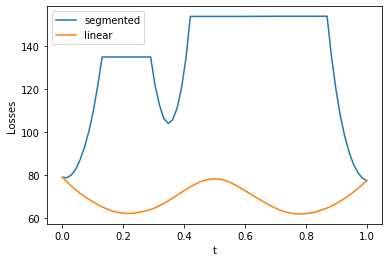

In [673]:
# => Plot risk on two paths
plt.plot(np.linspace(0,1,70),loss,label="segmented")
plt.plot(np.linspace(0,1,70),loss_linear,label="linear")
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('Losses')
plt.savefig("linear_vs_piecewise_linear.jpg")

In [565]:
np.shape(loss_linear)

(70,)